In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Exercice 1
Program the running mean

$$
\hat{\mu}_\lambda^{\mathrm{RM}}(x)=\frac{\sum_{j=1}^n y_j 1_{\left|x_j-x\right| \leq \lambda / 2}}{\sum_{j=1}^n 1_{\left|x_j-x\right| \leq \lambda / 2}}
$$

and running median estimators for a window width $\lambda>0$ to estimate the underlying function $\mu$ at any point $x \in \mathbb{R}$ based on a realisation $\left(y_1, \ldots, y_n\right)$ of

$$
Y_i=\mu\left(x_i\right)+\epsilon_i \quad \text { with } \quad \epsilon_i \stackrel{i . i . d .}{\sim} \mathrm{N}\left(0, \sigma^2\right) .
$$


Note that the $x_i$ 's are not necessarily equispaced. To estimate $\mu(x)$ at a point $x$ outside the range of the data $\left[x_{(1)}, x_{(n)}\right]$, we define

$$
\hat{\mu}_\lambda^{\mathrm{RM}}(x)=\left\{\begin{array}{ll}
\hat{\mu}_\lambda^{\mathrm{RM}}\left(x_{(1)}\right) & x \leq x_{(1)} \\
\hat{\mu}_\lambda^{\mathrm{RM}}\left(x_{(n)}\right) & x \geq x_{(n)}
\end{array} .\right.
$$

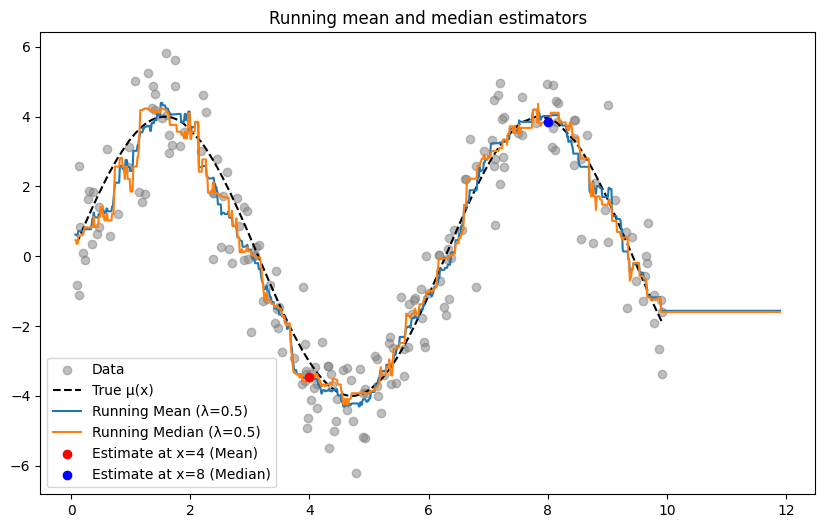

In [9]:
def neighbors_mask(x, x_data, lambda_=1):
    return np.abs(x_data - x) <= lambda_/2

def local_mean(x, x_data, y_data, lambda_=1):
    neighbors = neighbors_mask(x, x_data, lambda_)
    if not np.any(neighbors):
        return np.nan
    return np.mean(y_data[neighbors])

def local_median(x, x_data, y_data, lambda_=1):
    neighbors = neighbors_mask(x, x_data, lambda_)
    if not np.any(neighbors):
        return np.nan
    return np.median(y_data[neighbors])

def running_estimator(x_eval, x_data, y_data, lam, model='mean'):
    """
    Running mean estimator for arbitrary x.

    Parameters
    ----------
    x_eval : float or array-like
        Points at which to estimate μ(x)
    x_data : array-like
        Observed x_i values (not necessarily equispaced)
    y_data : array-like
        Observed y_i values
    lam : float
        Window width λ > 0
    model : str, optional
        'mean' for running mean, 'median' for running median (default is 'mean')

    Returns
    -------
    mu_hat : np.ndarray
        Running estimates at x_eval
    """
    x_eval = np.atleast_1d(x_eval)
    x_data = np.asarray(x_data)
    y_data = np.asarray(y_data)

    x_sorted = np.sort(x_data)

    if model == 'mean':
        local = local_mean
    elif model == 'median':
        local = local_median

    mu_hat = np.empty_like(x_eval, dtype=float)

    mask_inside = (x_eval > x_sorted[0]) & (x_eval < x_sorted[-1])
    inside_indices = np.where(mask_inside)[0]
    for idx in inside_indices:
        x = x_eval[idx]
        mu_hat[idx] = local(x, x_data, y_data, lam)

    mask_left = x_eval <= x_sorted[0]
    mu_hat[mask_left] = local(x_sorted[0], x_data, y_data, lam)

    mask_right = x_eval >= x_sorted[-1]
    mu_hat[mask_right] = local(x_sorted[-1], x_data, y_data, lam)

    return mu_hat

n = 200
x_data = np.sort(np.random.rand(n) * 10)
mu_true = lambda x: 4 * np.sin(x)
sigma = 1.0
y_data = mu_true(x_data) + sigma * np.random.randn(n)

x_eval = np.linspace(0.8*x_data[0], 1.2*x_data[-1], 1000)
lam = 0.5

# ---------------------------------------------------------------------
# Plot running mean and median
# ---------------------------------------------------------------------
mu_mean = running_estimator(x_eval, x_data, y_data, lam, model='mean')
mu_median = running_estimator(x_eval, x_data, y_data, lam, model='median')

plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, color='gray', alpha=0.5, label='Data')
plt.plot(x_data, mu_true(x_data), 'k--', label='True μ(x)')
plt.plot(x_eval, mu_mean, label=f'Running Mean (λ={lam})')
plt.plot(x_eval, mu_median, label=f'Running Median (λ={lam})')
plt.scatter(4, running_estimator(4, x_data, y_data, lam, 'mean'),
            color='red', zorder=5, label='Estimate at x=4 (Mean)')
plt.scatter(8, running_estimator(8, x_data, y_data, lam, 'median'),
            color='blue', zorder=5, label='Estimate at x=8 (Median)')
plt.legend()
plt.title("Running mean and median estimators")
plt.show()

### Exercice 2
For the choice of $\lambda$ :

1. Choose your best $\lambda$ by eye.
2. Since you are oracle, choose $\lambda$ by minimizing w.r.t. $\lambda$ the $\ell_2$ distance between $\hat{\mu}_\lambda^{\mathrm{RM}}$ and $\mu$ on a fine grid on $\left[x_{(1)}, x_{(n)}\right]$ : 
$$
\ell_2^2(\lambda)=\sum_{x_k \in \text { grid }}\left(\hat{\mu}_\lambda^{\mathrm{RM}}\left(x_k\right)-\mu\left(x_k\right)\right)^2 .
$$ You may want to plot the $\ell_2$ distance as a function of $\lambda$.
3. Simulate a validation set according to (1) and optimize its prediction as a function of $\lambda$.
4. Choose $\lambda$ by 2-fold cross-validation (odd versus even indexes). You may want to plot $\operatorname{CV}(\lambda)$ on the same plot as $\ell_2^2(\lambda)$.

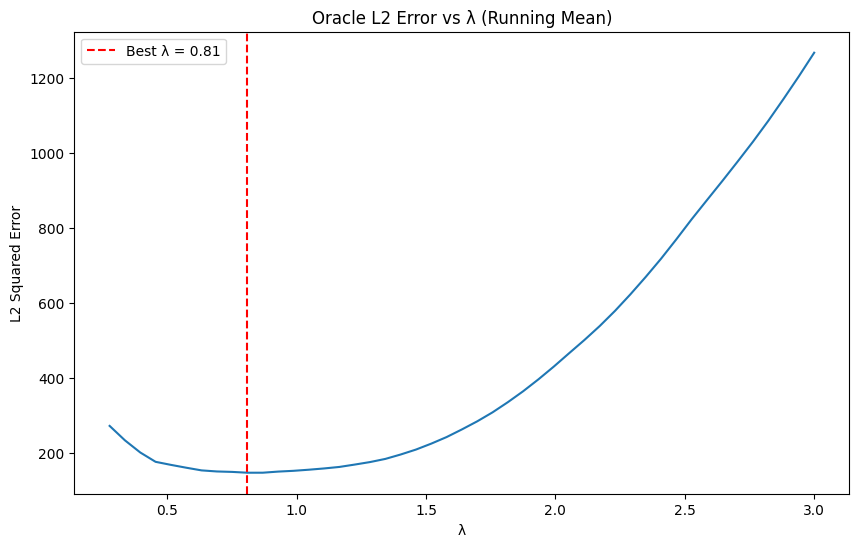

In [113]:
def l2_grid(lambda_values, x_data, y_data, true_mu, model='mean', grid_size=1000):
    x_grid = np.linspace(x_data.min(), x_data.max(), grid_size)
    mu_true_grid = true_mu(x_grid)
    l2_vals = []
    for lam in lambda_values:
        mu_hat = running_estimator(x_grid, x_data, y_data, lam, model=model)
        if np.isnan(mu_hat).any():
            l2_sq = np.inf
        else:
            l2_sq = np.sum((mu_hat - mu_true_grid)**2)
        l2_vals.append(l2_sq)
    l2_vals = np.asarray(l2_vals)
    lam_best = lambda_values[np.argmin(l2_vals)]
    return lam_best, l2_vals

lambda_values = np.linspace(0.1, 3.0, 50)
lam_best_L2, l2_vals = l2_grid(lambda_values, x_data, y_data, mu_true, model='mean')

plt.figure(figsize=(10, 6))
plt.plot(lambda_values, l2_vals)
plt.axvline(lam_best_L2, color='red', linestyle='--', label=f'Best λ = {lam_best_L2:.2f}')
plt.xlabel('λ')
plt.ylabel('L2 Squared Error')
plt.title('Oracle L2 Error vs λ (Running Mean)')
plt.legend()
plt.show()

1.	When $\lambda$ is too small, each window contains very few points (maybe 1 or 0) and the estimator is very noisy — it overfits the noise.
2.	When $\lambda$ is too large, each window includes too many points and the estimate is oversmoothed and cannot follow the oscillations.

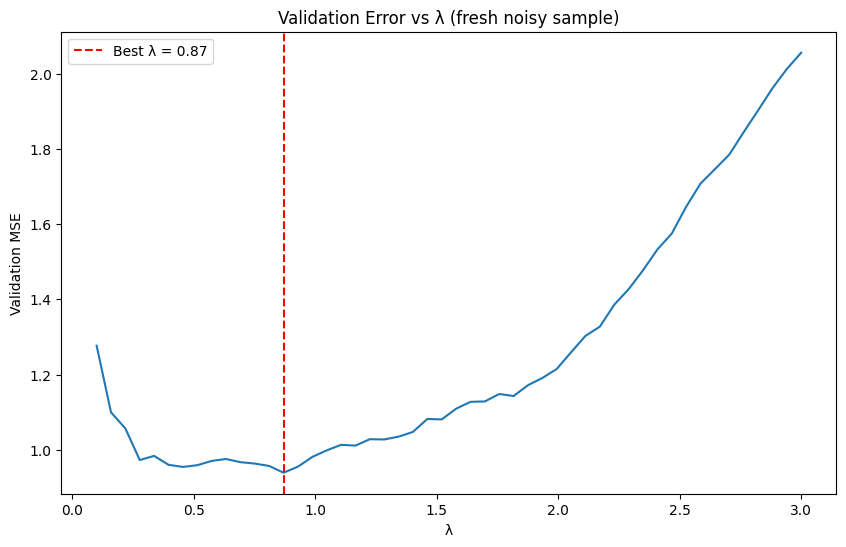

In [117]:
def validation_curve(lambda_values, x_data, y_data, mu_func, model='mean'):
    y_val = mu_func(x_data) + np.random.randn(len(x_data))
    val_errs = []
    for lam in lambda_values:
        y_pred = running_estimator(x_data, x_data, y_data, lam, model=model)
        val_errs.append(np.mean((y_pred - y_val)**2))
    val_errs = np.asarray(val_errs)
    lam_best = lambda_values[np.argmin(val_errs)]
    return lam_best, val_errs

lam_best_val, val_errs = validation_curve(lambda_values, x_data, y_data, mu_true, model='mean')

plt.figure(figsize=(10, 6))
plt.plot(lambda_values, val_errs)
plt.axvline(lam_best_val, color='red', linestyle='--', label=f'Best λ = {lam_best_val:.2f}')
plt.xlabel('λ')
plt.ylabel('Validation MSE')
plt.title('Validation Error vs λ (fresh noisy sample)')
plt.legend()
plt.show()

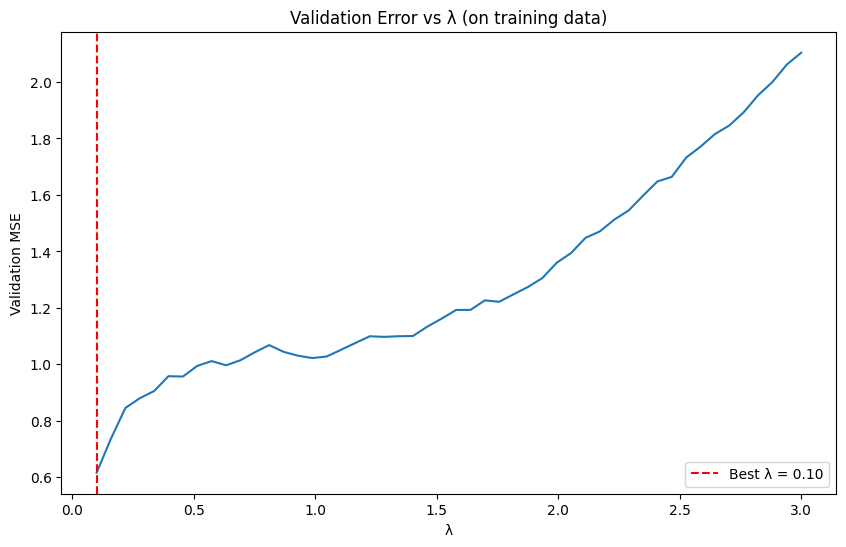

In [118]:
def validation_curve(lambda_values, x_data, y_data, mu_func, model='mean'):
    val_errs = []
    for lam in lambda_values:
        y_pred = running_estimator(x_data, x_data, y_data, lam, model=model)
        val_errs.append(np.mean((y_pred - y_data)**2))
    val_errs = np.asarray(val_errs)
    lam_best = lambda_values[np.argmin(val_errs)]
    return lam_best, val_errs

lam_best_val, val_errs = validation_curve(lambda_values, x_data, y_data, mu_true, model='mean')

plt.figure(figsize=(10, 6))
plt.plot(lambda_values, val_errs)
plt.axvline(lam_best_val, color='red', linestyle='--', label=f'Best λ = {lam_best_val:.2f}')
plt.xlabel('λ')
plt.ylabel('Validation MSE')
plt.title('Validation Error vs λ (on training data)')
plt.legend()
plt.show()

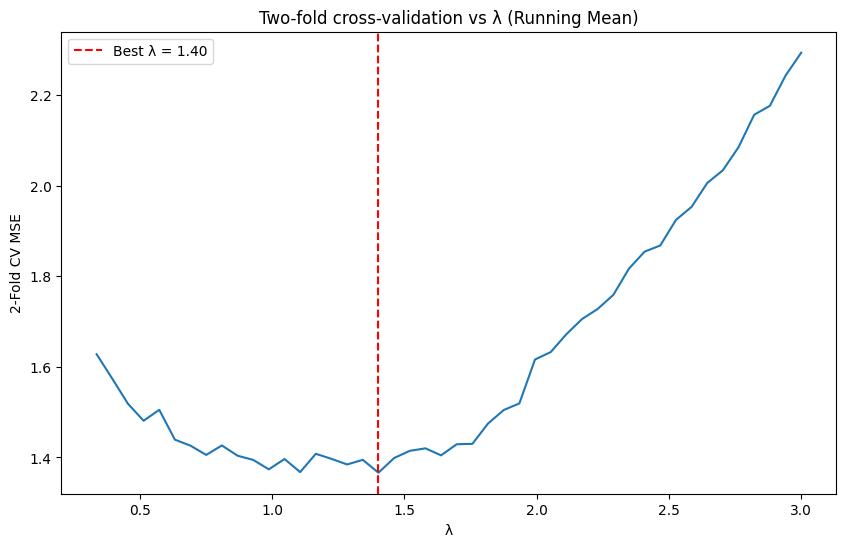

In [119]:
def two_fold_cv_curve(lambda_values, x_data, y_data, model='mean'):
    idx = np.arange(len(x_data))
    even, odd = (idx % 2 == 0), (idx % 2 == 1)

    def fold_mse(train_mask, test_mask, lam):
        x_train, y_train = x_data[train_mask], y_data[train_mask]
        x_test, y_test = x_data[test_mask], y_data[test_mask]
        y_pred = running_estimator(x_test, x_train, y_train, lam, model=model)
        if np.isnan(y_pred).any():
            return np.inf
        return np.mean((y_pred - y_test)**2)

    cv_vals = []
    for lam in lambda_values:
        mse1 = fold_mse(odd, even, lam)
        mse2 = fold_mse(even, odd, lam)
        cv_vals.append(0.5*(mse1 + mse2))
    cv_vals = np.asarray(cv_vals)
    lam_best = lambda_values[np.argmin(cv_vals)]
    return lam_best, cv_vals

lam_best_cv, cv_vals = two_fold_cv_curve(lambda_values, x_data, y_data, model='mean')

plt.figure(figsize=(10, 6))
plt.plot(lambda_values, cv_vals)
plt.axvline(lam_best_cv, color='red', linestyle='--', label=f'Best λ = {lam_best_cv:.2f}')
plt.xlabel('λ')
plt.ylabel('2-Fold CV MSE')
plt.title('Two-fold cross-validation vs λ (Running Mean)')
plt.legend()
plt.show()